In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time
import unidecode
from googletrans import Translator


In [2]:
with open('data/final/sampled_references_nl.json','r',encoding='utf-8') as f:
    json_nl = json.load(f)
    df = pd.DataFrame(json_nl)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    s1 = unidecode.unidecode(norm_string(s1))
    s2 = unidecode.unidecode(norm_string(s2))
    return textdistance.levenshtein.normalized_similarity(s1,s2)

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(20)

,index,netloc
0,rkd.nl,95
1,data.collectienederland.nl,31
2,cultureelerfgoed.nl,21
3,www.biografischportaal.nl,18
4,www.ebi.ac.uk,16
5,mskgent.be,15
6,viaf.org,12
7,data.kunsten.be,12
8,nl.wikipedia.org,11
9,www.rijksmuseum.nl,8


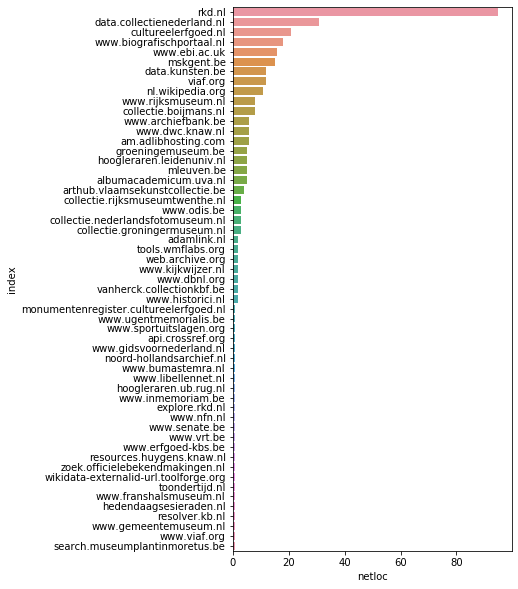

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## www.ebi.ac.uk
We see here that there are many types of predicates, but automating these many checks may be done.

Some here have the path for the api, some do not. We can only check those directed at the API, so we filter them. The ones filtered out are protein and gene databases which we'll check later.

### Article API

In [6]:
df_ebi = df[df['netloc'] == 'www.ebi.ac.uk']
df_ebi_api = df_ebi[df_ebi['path'] == '/europepmc/webservices/rest/search']
df_ebi_api['predicate'].value_counts(), df_ebi_api.shape[0]

(gepubliceerd in            4
 auteur (als tekenreeks)    3
 uitgave                    2
 volume                     2
 datum van uitgave          2
 pagina                     2
 is een                     1
 Name: predicate, dtype: int64,
 16)

In [7]:
def verify_ebi_api(row, verbose=True):
#for i, row in df_en_ebi_api.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    d = requests.get(row['url']).json()['resultList']['result']
    
    if compare(subject, d[0]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d[0]['title'])
        #break
        return found
    if predicate == 'is een':
        value = d[0]['pubTypeList']['pubType']
        if obj == 'wetenschappelijk artikel' \
            and 'Journal Article' in value \
            or 'Case Reports' in value \
            or 'Editorial' in value \
            or 'Letter' in value:
            found = True            
    elif predicate == 'datum van uitgave':
        value = d[0]['firstPublicationDate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'gepubliceerd in':
        obj = obj.replace('The BMJ','British medical journal')
        value = d[0]['journalInfo']['journal']['title']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = d[0]['doi']
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'auteur (als tekenreeks)':
        value = d[0]['authorList']['author']
        for author in value:
            #if 'fullName' in author:
            #    print('Full name:',author['fullName'])
            #if 'firstName' in author:
            #    print('First and last names:',author['firstName'] + ' ' + author['lastName'])
            #print(obj)
            if 'fullName' in author and compare(obj, author['fullName']) >= 0.99:
                found = True
            elif 'firstName' in author and compare(obj, author['firstName'] + ' ' + author['lastName']) >= 0.99:
                found = True
    elif predicate == 'volume':
        value = d[0]['journalInfo']['volume']
        if value == obj:
            found = True
    elif predicate == 'pagina':
        value = d[0]['pageInfo']
        if value == obj:
            found = True
    elif predicate == 'uitgave':
        value = d[0]['journalInfo']['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = d[0]['id']
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'titel':
        value = d[0]['title']
        if compare(obj, d[0]['title']) >= 0.9:
            found = True
    elif predicate == 'PMCID':
        value = d[0]['pmcid']
        if ('PMC'+obj) == value:
            found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ebi_api_verified = df_ebi_api.apply(verify_ebi_api,axis=1)
print('{}% are confirmed'.format(100*df_ebi_api_verified.sum()/len(df_ebi_api_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ebi_api.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_ebi_api[df_ebi_api_verified == False]

[Determinants of the
[Determinants of the (ir)regularity of dental attendance]
93.75% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
268,09c8d86082798b44509161c50bb5efb7f4a6b070,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,nl,Q69843859-D56E628C-9693-4E5B-9412-843C1FFEC7DC,[Determinants of the,auteur (als tekenreeks),Schuurs AH,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:3861956%20AND%20SRC:MED&resulttyp...,


## viaf.org

In [8]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

WorldCat Identities-identificatiecode    7
NTA-identificatiecode                    4
NKC-identificatiecode                    1
Name: predicate, dtype: int64

In [9]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    try:
        if type(d['mainHeadings']['data']) is not list:
            d['mainHeadings']['data']= [d['mainHeadings']['data']]
        names = [name['text'] for name in d['mainHeadings']['data']]
        for to_add in ['mainHeadings/mainHeadingEl','x400s/x400','x500s/x500']:
            to_add = to_add.split('/')
            if to_add[0] in d:
                if type(d[to_add[0]][to_add[1]]) != list:
                    d[to_add[0]][to_add[1]] = [d[to_add[0]][to_add[1]]]
                names_i = [i['datafield']['subfield'] for i in d[to_add[0]][to_add[1]]]
                names_i = [n if type(n) == list else [n] for n in names_i]
                names_i = [item['#text'] for sublist in names_i for item in sublist]
                names += names_i
    except Exception:
        print(url)
        print(d)
        raise

    if all([compare(subject,name) < 0.9 for name in names]) and subject not in ['Willem van Haecht']:
        if verbose:
            print(url)
            print(subject)
            print(names)
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'BNF ID':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj.startswith(value):
            found = True
    elif predicate == 'WorldCat Identities-identificatiecode':
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    elif predicate == 'NTA-identificatiecode':
        value = [i for i in flat_ids if i.startswith('NTA|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'NKC-identificatiecode':
        value = [i for i in flat_ids if i.startswith('NKC|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'GND ID':
        value = [i for i in flat_ids if i.startswith('DNB|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'VIAF':
        if obj in [viaf_id]:
            found = True
    elif predicate == 'LCAuth':
        value = [i for i in flat_ids if i.startswith('LC|')][0].split('|')[-1].replace(' ','')
        if obj in [value]:
            found = True
    elif predicate == 'födelsedatum':
        value = d['birthDate']
        if obj.startswith(value):
            found = True
    elif predicate == 'ISNI':
        value = [i for i in flat_ids if i.startswith('ISNI|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    elif predicate == 'SELIBR ID':
        value = [i for i in flat_ids if i.startswith('SELIBR|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    else:
        print(flat_ids)
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf.index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### testing other netlocs

In [32]:
df_ = df[df['netloc'] == 'www.odis.be']
df_['predicate'].value_counts()

geboortedatum                      2
datum van oprichting of creatie    1
Name: predicate, dtype: int64

In [30]:
df_[df_['predicate'] == 'inventarisnummer']

,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
133,f86b2864a983c3feae0a815784a975096eb83a29,http://mleuven.be/collection/work/id/C_254,"{'retrieved': 'time:>+2016-01-24T00:00:00Z', '...",nl,Q22252725-8D530CAE-FC67-4876-B28D-51C25155C236,De zaaier,inventarisnummer,C/254,0,False,http,mleuven.be,/collection/work/id/C_254,,,
200,c8b5bcb5b442672a4d991ed13a2cbbfc6d0d930a,http://mleuven.be/collection/data/LP_372,{'reference URL': 'url:>http://mleuven.be/coll...,nl,Q21999558-104755FB-8A38-446B-88FF-4015C090EC4C,De Sint-Jacobskerk met pestkerkhof in Leuven,inventarisnummer,LP/372,0,False,http,mleuven.be,/collection/data/LP_372,,,


# Save files

In [24]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_nl if j['reference_id'] in not_verified_reference_ids]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_nl_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 312. That is 91.76470588235294% left from the total.


In [25]:
def is_wikipedia(url):
    if url.startswith('https://nl.wikipedia.org'):
        return True
    elif url.startswith('https://en.wikipedia.org'):
        return True
    return False

not_verified_references_non_wikipedia = [r for r in not_verified_references if not is_wikipedia(r['url'])]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_nl_auth.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references_non_wikipedia,f ,indent=2,ensure_ascii=False)